In [1]:
import cv2
import numpy as np

ModuleNotFoundError: No module named 'cv2'

In [2]:
import math

In [3]:
import matplotlib.pyplot as plt

In [53]:
xray = cv2.imread('xray.png',-1)

In [5]:
def zigzag(matrix):
    # Get the number of rows and columns in the matrix
    rows = len(matrix)
    cols = len(matrix[0])

    # Create an empty list to store the zigzag ordering
    zigzag = []
    temp = np.zeros((1,rows*cols))

    # Initialize the starting row and column
    row, col = 0, 0

    # Iterate over each diagonal of the matrix
    for i in range(rows + cols - 1):
        # If the diagonal is even, traverse it from top-right to bottom-left
        if i % 2 == 0:
            while row >= 0 and col < cols:
                zigzag.append(matrix[row][col])
                row -= 1
                col += 1
            if row < 0 and col <= cols - 1:
                row = 0
            if col == cols:
                row += 2
                col -= 1
        # If the diagonal is odd, traverse it from bottom-left to top-right
        else:
            while col >= 0 and row < rows:
                zigzag.append(matrix[row][col])
                row += 1
                col -= 1
            if col < 0 and row <= rows - 1:
                col = 0
            if row == rows:
                col += 2
                row -= 1
    zigzag = np.array(zigzag)
    zigzag = np.reshape(zigzag,(-1,matrix.shape[0]))
    
    return zigzag

In [6]:
def reverse_zigzag_for8x8(matrix):
    for i in range(135):
        matrix= zigzag(matrix)
    return matrix

In [7]:
def run_length_encode(input_string):
    # Initialize the encoded string and the counter
    encoded_string = ''
    count = 1

    # Iterate over each character in the input string
    for i in range(1, len(input_string)):
        if input_string[i] == input_string[i-1]:
            # If the current character is the same as the previous one, increment the counter
            count += 1
        else:
            # If the current character is different from the previous one, add the count and the character to the encoded string
            count_str = str(count)
            encoded_string += count_str + "," +str(input_string[i-1]) + "."
            count = 1

    # Add the final count and character to the encoded string
    encoded_string += str(count) +"," + str(input_string[-1]) 

    return encoded_string     

In [133]:
block_size = 4
#quantization matrix:
quantization_matrix8x8 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])
quantization_matrix = np.array([[1,2,4,8],[2,2,4,8],[4,4,4,8],[8,8,8,8]])

In [134]:
#calculation for number of blocks needed
h,w = xray.shape
height = np.int32(h)
width = np.int32(w)
h,w = np.float32(h),np.float32(w)

nbh = np.int32(math.ceil(h/block_size))
nbw = np.int32(math.ceil(w/block_size))

#Height of padded image
H = block_size * nbh
W = block_size * nbw

padded_img = np.zeros((H,W))
padded_img[0:height,0:width] = xray[0:height,0:width]

padded_img_minus128 = padded_img - 128
#cv2.imwrite('uncompressed.bmp',np.uint8(padded_img))

(-0.5, 1023.5, 1023.5, -0.5)

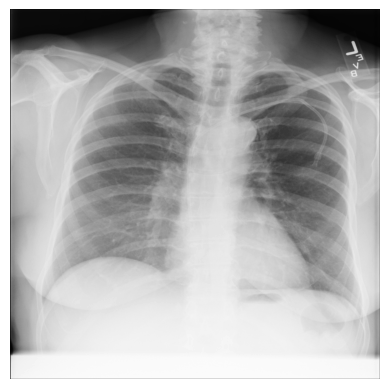

In [135]:
plt.imshow(padded_img_minus128,cmap='gray')
plt.axis('off')

In [136]:
final = np.zeros(xray.shape)
for i in range(nbh):
    #compute start and end row index of block
    row_ind_1 = i*block_size
    row_ind_2 = row_ind_1 + block_size
    
    
    for j in range(nbw):
        #compute start and end column index of block
        col_ind_1 = j*block_size
        col_ind_2 = col_ind_1 + block_size
        
        block = padded_img_minus128[row_ind_1 : row_ind_2, col_ind_1:col_ind_2]
        
        #applying 2D DCT to block
        DCT = cv2.dct(block)
        
        quantized = np.round(np.divide(DCT,quantization_matrix))
        
        reordered = zigzag(quantized)
        
        #reshaped = np.reshape(reordered,(block_size,block_size))
        
        final[row_ind_1:row_ind_2,col_ind_1:col_ind_2] = reordered

array([[-408.,  -30.,   -6., ...,    3.,   -2.,   -1.],
       [   4.,   -7.,    1., ...,   -2.,    1.,    0.],
       [   2.,   -1.,    1., ...,   -1.,   -0.,    0.],
       ...,
       [ -25.,  -29.,    5., ...,  -29.,    8.,   -4.],
       [  11.,    5.,   -3., ...,    7.,    1.,    3.],
       [   1.,   -0.,   -1., ...,   -1.,   -1.,    0.]])

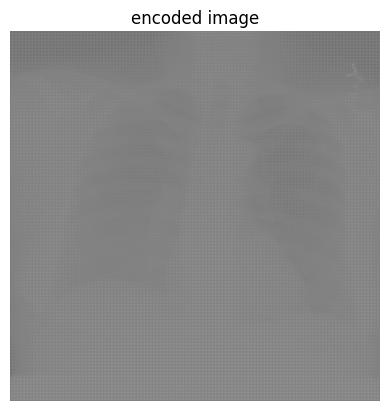

In [137]:
plt.imshow(final,cmap='gray')
plt.axis('off')
plt.title("encoded image")
final

In [138]:
arranged = final.flatten()

In [139]:
arranged.shape

(1048576,)

In [140]:
bitstream = run_length_encode(arranged)
#bitstream

In [141]:
bitstream2 = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + bitstream + ";"

In [142]:
file1 = open('test2.txt','w')
file1.write(bitstream2)
file1.close()

In [143]:
def rl_decode(g,shape):

    l = g.split(".")
    final = []
    for i in l:
        temp = i.split(',')
        final.append(np.int32(temp))
    
    #final
    final_arr = []
    for i in final:
        for j in range(i[0]):
            final_arr.append(i[1])
        
    k = np.array(final_arr)

    return k.reshape(shape)

In [144]:
decoded = rl_decode(bitstream,xray.shape)
decoded

array([[-408,  -30,   -6, ...,    3,   -2,   -1],
       [   4,   -7,    1, ...,   -2,    1,    0],
       [   2,   -1,    1, ...,   -1,    0,    0],
       ...,
       [ -25,  -29,    5, ...,  -29,    8,   -4],
       [  11,    5,   -3, ...,    7,    1,    3],
       [   1,    0,   -1, ...,   -1,   -1,    0]])

In [145]:
decoded.shape

(1024, 1024)

In [146]:
decoded,final #should be equal to final

(array([[-408,  -30,   -6, ...,    3,   -2,   -1],
        [   4,   -7,    1, ...,   -2,    1,    0],
        [   2,   -1,    1, ...,   -1,    0,    0],
        ...,
        [ -25,  -29,    5, ...,  -29,    8,   -4],
        [  11,    5,   -3, ...,    7,    1,    3],
        [   1,    0,   -1, ...,   -1,   -1,    0]]),
 array([[-408.,  -30.,   -6., ...,    3.,   -2.,   -1.],
        [   4.,   -7.,    1., ...,   -2.,    1.,    0.],
        [   2.,   -1.,    1., ...,   -1.,   -0.,    0.],
        ...,
        [ -25.,  -29.,    5., ...,  -29.,    8.,   -4.],
        [  11.,    5.,   -3., ...,    7.,    1.,    3.],
        [   1.,   -0.,   -1., ...,   -1.,   -1.,    0.]]))

In [147]:
(decoded==final).all()

True

(-0.5, 1023.5, 1023.5, -0.5)

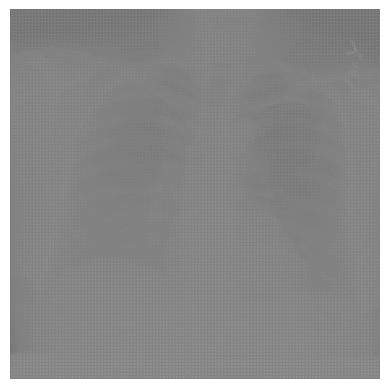

In [148]:
plt.imshow(decoded,cmap='gray')
plt.axis('off')

In [149]:
uncompressed = np.zeros(decoded.shape)
for i in range(nbh):
    #compute start and end row index of block
    row_ind_1 = i*block_size
    row_ind_2 = row_ind_1 + block_size
    
    
    
    for j in range(nbw):
        #compute start and end column index of block
        col_ind_1 = j*block_size
        col_ind_2 = col_ind_1 + block_size
        
        block = decoded[row_ind_1 : row_ind_2, col_ind_1:col_ind_2]
        
        #applying 2D IDCT to block
        
        reordered = reverse_zigzag_for8x8(block)
        
        dequantized_block = np.round(np.multiply(block,quantization_matrix)).astype(np.float64)
        IDCT = cv2.idct(dequantized_block)
        
        #reshaped = np.reshape(reordered,(block_size,block_size))
        
        uncompressed[row_ind_1:row_ind_2,col_ind_1:col_ind_2] = IDCT
    

In [150]:
uncompressed2 =np.uint8(uncompressed) + 128
uncompressed2

array([[  0,  25,  44, ...,  15,  11,  14],
       [251,  32,  32, ...,  17,  10,   9],
       [251,  36,  26, ...,  19,  11,   7],
       ...,
       [ 11,  74,  67, ..., 227,  55,   8],
       [ 44, 101,  99, ..., 235,  74, 231],
       [103, 123, 144, ..., 210,  65, 166]], dtype=uint8)

In [128]:
(xray==uncompressed2).all()

False

(-0.5, 1023.5, 1023.5, -0.5)

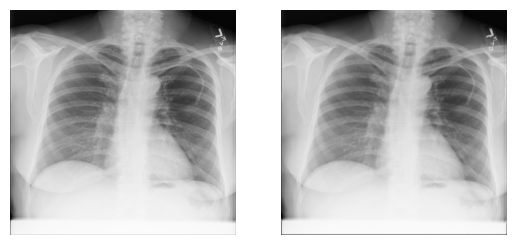

In [151]:
plt.subplot(1,2,1)
plt.imshow(xray,cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(uncompressed2,cmap='gray')
plt.axis('off')

In [152]:
def rmse(img1,img2):
    mse = np.square(np.subtract(img1,img2)).mean()
    rmse = math.sqrt(mse)
    return rmse

def snr(filtered_img,original_img):
    num = np.square(filtered_img).sum()
    diff_sq = np.square(filtered_img - original_img)
    denom = np.sum(diff_sq)
    snr = num/denom
    return snr

In [153]:
rmse_jpeg = rmse(uncompressed2,xray)
snr_jpeg = snr(uncompressed2,xray)
print(f"For JPEG: RMSE = {rmse_jpeg} | SNR = {snr_jpeg}")

For JPEG: RMSE = 3.782245347350395 | SNR = 7.519069846572177


In [154]:
cv2.imwrite("JPEG Reconstructed Img 4x4 block size.jpeg",uncompressed2)

True

In [3]:
compression_ratio = 117020/1049654
compression_rate = 1/compression_ratio
compression_ratio, compression_rate

(0.11148435579724367, 8.969868398564348)